# 支持向量机分类器

这个ipython notebook包括如下的内容
    
- 完成基于hinge loss的SVM
- 完成解析梯度的向量化计算
- 会用数值梯度去校验解析梯度的准确性
- 用验证集去调正则化和学习率
- 用随机梯度下降最小化损失函数
- 可视化结果权重


In [1]:
import random
import numpy as np
from basic.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 初始化的工作
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10数据集载入与预处理

In [2]:
# 加载原始的CIFAR-10图片数据集
cifar10_dir = 'basic/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 看一眼训练集和测试集维度
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


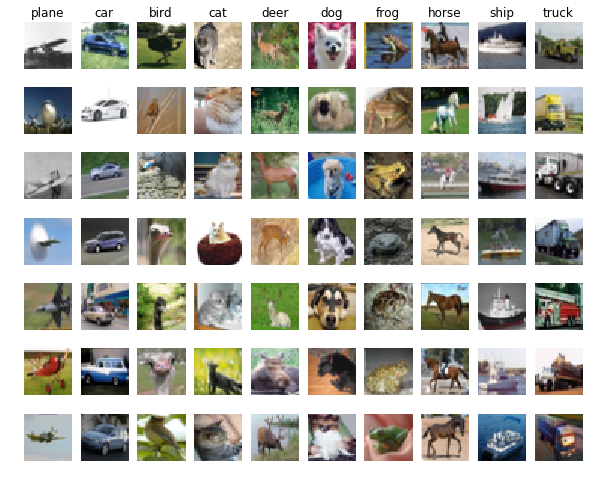

In [3]:
# 可视化一下图片集，每个类别展示一些图片
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# 抽取训练集/交叉验证集/测试集
num_training = 49000
num_validation = 1000
num_test = 1000

# 取图
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]


mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# 预处理：把数据展成一列
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# 看一眼训练集和测试集维度
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


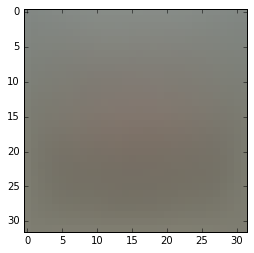

In [6]:
# 预处理：减去图像均值
# 先求出训练集的均值
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # 输出一些均值数据看看
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # 可视化一下

In [7]:
# 然后从训练集和测试集里面减去图像均值
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
# 咱们把bias那一列1都加上
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

# 看一眼维度
print X_train.shape, X_val.shape, X_test.shape

(3073, 49000) (3073, 1000) (3073, 1000)


## SVM 分类器

svm部分的代码在 **basic/classifiers/linear_svm.py**. 

In [9]:
# 评估一下用for循环完成的svm_loss_naive的效果和效率:
from basic.classifiers.linear_svm import svm_loss_naive
import time

# 产出SVM的初始权重
W = np.random.randn(10, 3073) * 0.0001 
loss, grad = svm_loss_naive(W, X_train, y_train, 0.00001)
print '损失值loss: %f' % (loss, )

损失值loss: 8.625512


In [10]:
# 咱们完成一下梯度的求解
# 然后做一下梯度检查

# 计算W下的梯度和损失.
loss, grad = svm_loss_naive(W, X_train, y_train, 0.0)

# 梯度检查，要检查数值梯度和解析梯度是否一致，因为解析梯度计算快，但是容易出错
from basic.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -25.437076 analytic: -25.438081, relative error: 0.000
numerical: -8.102688 analytic: -8.106332, relative error: 0.000
numerical: -5.613130 analytic: -5.610872, relative error: 0.000
numerical: -3.240808 analytic: -3.240564, relative error: 0.000
numerical: -9.209724 analytic: -9.209351, relative error: 0.000
numerical: 20.601202 analytic: 20.602558, relative error: 0.000
numerical: 16.505994 analytic: 16.506960, relative error: 0.000
numerical: -0.199122 analytic: -0.202682, relative error: 0.009
numerical: -9.011518 analytic: -9.010755, relative error: 0.000
numerical: 5.937820 analytic: 5.937931, relative error: 0.000


In [11]:
# 然后咱们实现了一个非向量化的svm损失计算
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print '非向量化的实现: 损失结果 %e 花费时间 %fs' % (loss_naive, toc - tic)

# 然后看看向量化的实现
from basic.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print '向量化的实现: 损失结果 %e 花费时间 %fs' % (loss_vectorized, toc - tic)

# 一般来说，如果你实现得正确，两个损失计算的结果是一致的，但是向量化的计算方法会快很多
print '两种方法差别: %f' % (loss_naive - loss_vectorized)

非向量化的实现: 损失结果 8.625512e+00 花费时间 2.541388s
向量化的实现: 损失结果 8.625512e+00 花费时间 0.259623s
两种方法差别: -0.000000


In [12]:
from basic.classifiers.linear_svm import svm_loss_vectorized
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, 0.00001)

In [13]:
# 咱们再比对一下2边的梯度是否一致
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print '非向量化的实现计算损失和梯度花费时间 %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print '向量化的实现计算损失和梯度花费时间 %fs' % (toc - tic)

# loss是一个值，直接比较就可以，但是梯度是一个矩阵，因此我们得用矩阵/向量的距离
difference = np.linalg.norm(grad_naive - grad_vectorized)
print '两种方法差别: %f' % difference

非向量化的实现计算损失和梯度花费时间 2.630363s
向量化的实现计算损失和梯度花费时间 0.284462s
两种方法差别: 0.000000


### 随机梯度下降

这是最小化损失函数的一种实现方法，虽然你还没有学到，但是可以提前感受一下。

In [14]:
# 实现随机梯度下降，再run一下
from basic.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print '总共训练花费时间 %fs' % (toc - tic)

iteration 0 / 1500: loss 785.058917
iteration 100 / 1500: loss 286.003451
iteration 200 / 1500: loss 107.616349
iteration 300 / 1500: loss 42.085145
iteration 400 / 1500: loss 18.811502
iteration 500 / 1500: loss 10.551674
iteration 600 / 1500: loss 6.617618
iteration 700 / 1500: loss 5.541120
iteration 800 / 1500: loss 5.486841
iteration 900 / 1500: loss 5.259669
iteration 1000 / 1500: loss 4.656431
iteration 1100 / 1500: loss 5.494512
iteration 1200 / 1500: loss 5.433520
iteration 1300 / 1500: loss 4.985693
iteration 1400 / 1500: loss 4.477447
总共训练花费时间 4.733009s


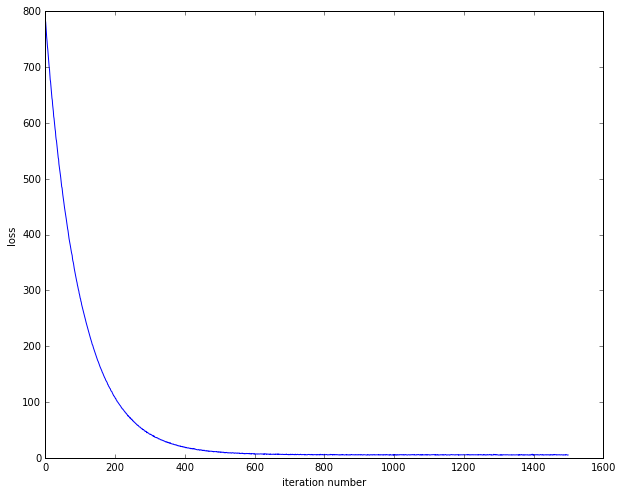

In [21]:
# 我们画出来随着迭代次数增多，损失的变化状况
plt.plot(loss_hist)
plt.xlabel('iteration number')
plt.ylabel('loss')

In [22]:
# 对样本进行预测并计算准确度
y_train_pred = svm.predict(X_train)
print '训练准确率: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print '验证集上准确率: %f' % (np.mean(y_val == y_val_pred), )

训练准确率: 0.370980
验证集上准确率: 0.379000


In [23]:
from basic.classifiers import LinearSVM
# 我们用交叉验证的方式测试不同的学习率
learning_rates = [5e-7, 1e-7, 5e-6, 1e-6, 1e-5]
regularization_strengths = [5e4, 1e5]

results = {}
best_val = -1   # 设定交叉验证最佳得分的初始值
best_svm = None # 设定交叉验证最佳svm参数集的初始值

verbose = True
for lr in learning_rates:
    for reg in regularization_strengths:
        if verbose: print "Training with hyper parameter learning rate: %e, regularization: %e " % ( lr, reg )
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)
        
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[lr, reg] = (training_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
            
# 输出结果
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print '学习率 %e 正则化系数 %e 训练准确率: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print '在交叉验证集上最好的准确率为: %f' % best_val

Training with hyper parameter learning rate: 5.000000e-07, regularization: 5.000000e+04 
Training with hyper parameter learning rate: 5.000000e-07, regularization: 1.000000e+05 
Training with hyper parameter learning rate: 1.000000e-07, regularization: 5.000000e+04 
Training with hyper parameter learning rate: 1.000000e-07, regularization: 1.000000e+05 
Training with hyper parameter learning rate: 5.000000e-06, regularization: 5.000000e+04 
Training with hyper parameter learning rate: 5.000000e-06, regularization: 1.000000e+05 
Training with hyper parameter learning rate: 1.000000e-06, regularization: 5.000000e+04 
Training with hyper parameter learning rate: 1.000000e-06, regularization: 1.000000e+05 
Training with hyper parameter learning rate: 1.000000e-05, regularization: 5.000000e+04 
Training with hyper parameter learning rate: 1.000000e-05, regularization: 1.000000e+05 
学习率 1.000000e-07 正则化系数 5.000000e+04 训练准确率: 0.373633 val accuracy: 0.376000
学习率 1.000000e-07 正则化系数 1.000000e+05

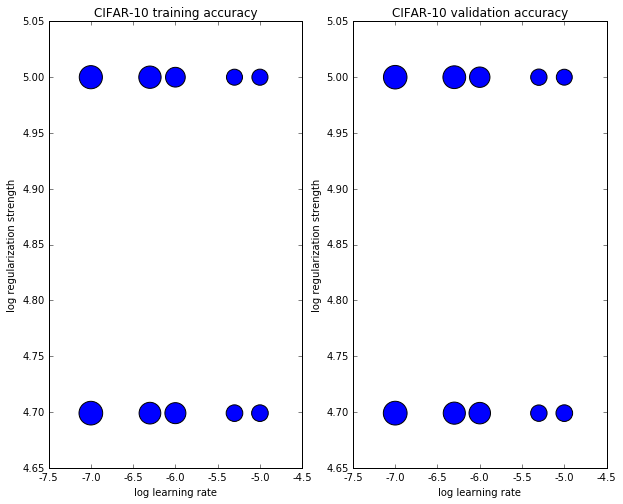

In [24]:
# 可视化交叉验证的结果
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# 画出训练准确率
sz = [results[x][0]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# 画出交叉验证集上的准确率
sz = [results[x][1]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

In [25]:
# 在测试集上看效果
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print '在图像原始像素数据上训练的linear SVM分类器在实际测试集上的准确率为: %f' % test_accuracy

在图像原始像素数据上训练的linear SVM分类器在实际测试集上的准确率为: 0.367000


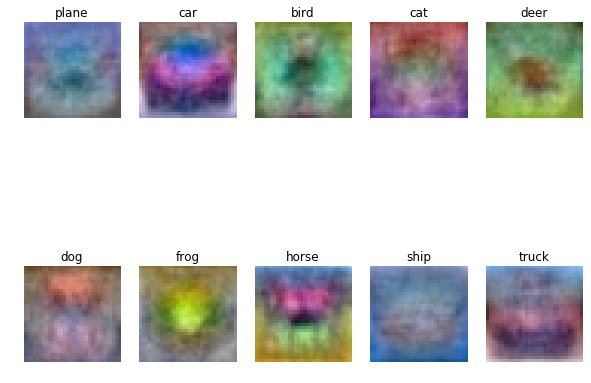

In [26]:
# 可视化每个类对应的权重
# 需要多说一句的是，因为初始值和学习率等的不同，你看到的结果可能会有一些差别
w = best_svm.W[:,:-1] # 去掉bias项
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])